<img src="covid19-banner.jpg">

# Looking at South Korea's COVID-19 Response #
<i> Author: Roshan Lodha </i> <br>
Source: <a href='https://www.kaggle.com/kimjihoo/coronavirusdataset#PatientInfo.csv'>datartist on Kaggle</a><br>
<a href="./Analysis of South Korea's COVID-19 Response.ipynb" download>Download</a> this notebook.

South Korea's response to the novel coronavirus was praised worldwide as one of the most immediate and effective responses of any nation. This response was in part due to the high volume of data available not only to physicians but also the public. Here we explore how just a small subset of the data can be used to study the impact of the virus and model its outcomes. 

Assumptions:
* The three thousand or so entries provided in this dataset are a representative and unbiased sample of South Korea's true case distribution. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # suppress warning; default='warn'
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
patients = pd.read_csv('PatientInfo.csv')
patients.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


## The Data ##
Data Keys:
* patient_id: the ID of the patient
* global_num: the number given by KCDC
* sex: the sex of the patient
* birth_year: the birth year of the patient
* age: the age of the patient
* country: the country of the patient
* province: the province of the patient
* city: the city of the patient
* disease: TRUE: underlying disease / FALSE: no disease
* infection_case: the case of infection
* infection_order: the order of infection
* infected_by: the ID of who infected the patient
* contact_number: the number of contacts with people
* symptom_onset_date: the date of symptom onset
* confirmed_date: the date of being confirmed
* released_date: the date of being released
* deceased_date: the date of being deceased
* state: isolated / released / deceased

A lot of the data is either missing or has nonsensical values. Thus, we must clean the data. The largets known factor heavily covarying with the novel coronavirus's mortality rate is age, so it is a good place to start with cleaning and subsequent visualizations. 

In [3]:
data = patients.drop(columns=['patient_id', 'global_num', 'birth_year', 'age', 'disease', 'infected_by'])
print("Entries with no age:", len(patients[patients['age'].isnull()]))
print("Entries with no birth year:", len(patients[patients['birth_year'].isnull()]))

Entries with no age: 105
Entries with no birth year: 464


In [4]:
date_by_age = patients['age'].fillna('0').str.extract(r'(\d+)').astype(int)
date_by_birth_year = 2020-patients['birth_year'].fillna(2020)
data['age'] = pd.concat([date_by_age, date_by_birth_year], axis=1).max(axis=1)
print("Entries with no age or birth year:", len(data[data['age'].isnull()]))
data.head(5)

Entries with no age or birth year: 0


,sex,country,province,city,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,age
0,male,Korea,Seoul,Gangseo-gu,overseas inflow,1.0,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0
1,male,Korea,Seoul,Jungnang-gu,overseas inflow,1.0,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0
2,male,Korea,Seoul,Jongno-gu,contact with patient,2.0,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0
3,male,Korea,Seoul,Mapo-gu,overseas inflow,1.0,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0
4,female,Korea,Seoul,Seongbuk-gu,contact with patient,2.0,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0


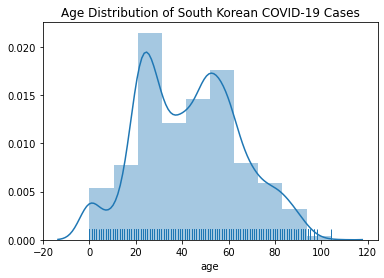

In [5]:
plt.title("Age Distribution of South Korean COVID-19 Cases")
ax1 = sns.distplot(data['age'], rug=True, bins=10)

We can now start cleaning other variables.

In [6]:
print("Entries with no infection order:", len(data[data['infection_order'].isnull()]))
print("Entries with no symptom onset date:", len(data[data['symptom_onset_date'].isnull()]))
print("Entries with no confirmed date:", len(data[data['confirmed_date'].isnull()])) #should be 0
print("Entries with a contact value:", len(data[data['contact_number'].notnull()])) 
print("Entries with an infection order:", len(data[data['infection_order'].notnull()]))

Entries with no infection order: 3097
Entries with no symptom onset date: 2682
Entries with no confirmed date: 0
Entries with a contact value: 589
Entries with an infection order: 31


Python has a built in "DateTime" object, that allows for handy manipulation of dates. We can convert all data-like columns to DateTime object for futher analysis.

In [7]:
data['symptom_onset_date'] = pd.to_datetime(data['symptom_onset_date'].replace(" ", ""), 
                               format='%Y-%m-%d')
data['confirmed_date'] = pd.to_datetime(data['confirmed_date'].replace(" ", ""), 
                                 format='%Y-%m-%d')
data['released_date'] = pd.to_datetime(data['released_date'].replace(" ", ""), 
                                 format='%Y-%m-%d')
data['time_before_hospitalization'] = data['confirmed_date'] - data['symptom_onset_date']
data['time_in_hospital'] = data['released_date'] - data['confirmed_date'] #death or otherwise
data.head(5)

,sex,country,province,city,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,age,time_before_hospitalization,time_in_hospital
0,male,Korea,Seoul,Gangseo-gu,overseas inflow,1.0,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0,1 days,13 days
1,male,Korea,Seoul,Jungnang-gu,overseas inflow,1.0,31.0,NaT,2020-01-30,2020-03-02,NaN,released,33.0,NaT,32 days
2,male,Korea,Seoul,Jongno-gu,contact with patient,2.0,17.0,NaT,2020-01-30,2020-02-19,NaN,released,56.0,NaT,20 days
3,male,Korea,Seoul,Mapo-gu,overseas inflow,1.0,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0,4 days,16 days
4,female,Korea,Seoul,Seongbuk-gu,contact with patient,2.0,2.0,NaT,2020-01-31,2020-02-24,NaN,released,28.0,NaT,24 days


In [8]:
cases_by_day = data.groupby('confirmed_date').count()[['sex']].reset_index().rename(columns={'sex':'count'})
cases_by_day['cumulative_sum'] = cases_by_day['count'].cumsum()
cases_by_day

,confirmed_date,count,cumulative_sum
0,2020-01-20,1,1
1,2020-01-23,1,2
2,2020-01-26,1,3
3,2020-01-27,1,4
4,2020-01-30,3,7
...,...,...,...
60,2020-04-03,24,2982
61,2020-04-04,21,3003
62,2020-04-05,15,3018
63,2020-04-06,11,3029


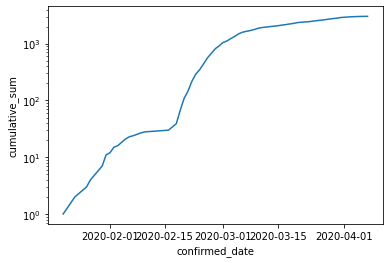

In [9]:
ax7 = sns.lineplot(x='confirmed_date', y='cumulative_sum', data=cases_by_day)
suppressor = ax7.set_yscale('log')

In [10]:
print("Average time to confirm after symptom onset:", np.mean(data['time_before_hospitalization']))
print("Average time to release after confirmed:", np.mean(data['time_in_hospital']))

Average time to confirm after symptom onset: 4 days 07:03:54.606741
Average time to release after confirmed: 20 days 05:47:53.394495


In [11]:
#time in hospital by infection type
print("Entries with no infection case and no hospitalization time:",
      sum(data.dropna(subset=['time_in_hospital'])['infection_case'].isnull()))

Entries with no infection case and no hospitalization time: 454


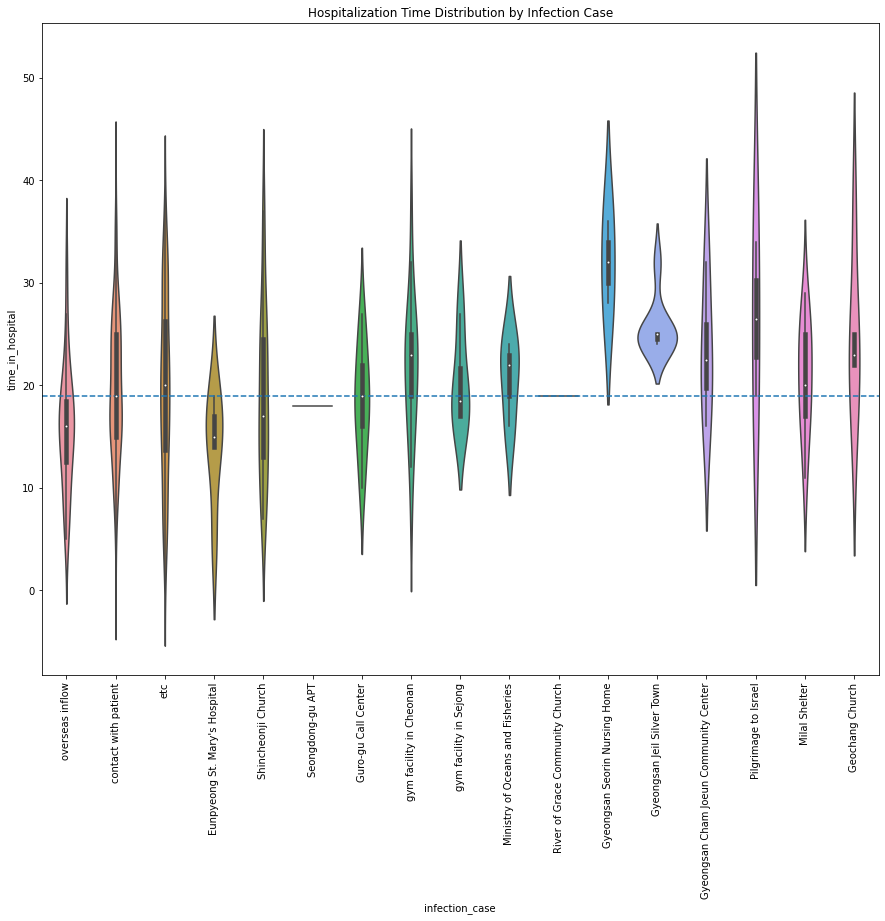

In [12]:
temp_data = data.dropna(subset=['infection_case', 'time_in_hospital'])
temp_data['time_in_hospital'] = temp_data['time_in_hospital'].apply(pd.Timedelta.total_seconds) / (24*60*60)
plt.figure(figsize=(15,12))
plt.title("Hospitalization Time Distribution by Infection Case")
ax2 = sns.violinplot(x='infection_case', y='time_in_hospital', 
                     data=temp_data)
ax2.axhline(np.median(temp_data['time_in_hospital']), ls='--')
suppressor = ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

After plotting the infection's cause against the time spent in the hospital, a few things immediately pop out. Specifically, we can see that patients who were infected in a nursing home (associated with high age) spent well above the median time in this hospital (dotted blue line). This is something we would have expected, indicating that our analysis is sound. Similarly, a quick Google search of the "Gyeongsan Seorin Silver Town" reveals that it is a silver mine, a location likely to have poor respiratory health. We know that COVID-19 attacks the respiratory system, so this makes sense. 

In [13]:
from statsmodels.stats.weightstats import ztest
t, p = ztest(x1=temp_data[temp_data['infection_case']=='Gyeongsan Jeil Silver Town']['time_in_hospital'],
            value=np.mean(temp_data['time_in_hospital']))
print("P-value:", p)
print("T-statistic:", t)

P-value: 2.2730538888858298e-08
T-statistic: 5.589819789370226


## Modeling ##
Since our data is more or less cleaned, and we have some idea of factors that could be impact mortality rate, we can start begin modeling. Our input variables could be anything that could help predict mortality and our output is the probability of dying given our input. This relationship ($P(Y|X)$) is best mathematically modeled by a <a href='https://en.wikipedia.org/wiki/Logistic_regression'>logistic regression</a>.

In [14]:
data['dead'] = (data['state'].factorize()[0] == 2).astype(int) #0: alive; 1: dead
data.head(5)

,sex,country,province,city,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,age,time_before_hospitalization,time_in_hospital,dead
0,male,Korea,Seoul,Gangseo-gu,overseas inflow,1.0,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0,1 days,13 days,0
1,male,Korea,Seoul,Jungnang-gu,overseas inflow,1.0,31.0,NaT,2020-01-30,2020-03-02,NaN,released,33.0,NaT,32 days,0
2,male,Korea,Seoul,Jongno-gu,contact with patient,2.0,17.0,NaT,2020-01-30,2020-02-19,NaN,released,56.0,NaT,20 days,0
3,male,Korea,Seoul,Mapo-gu,overseas inflow,1.0,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0,4 days,16 days,0
4,female,Korea,Seoul,Seongbuk-gu,contact with patient,2.0,2.0,NaT,2020-01-31,2020-02-24,NaN,released,28.0,NaT,24 days,0


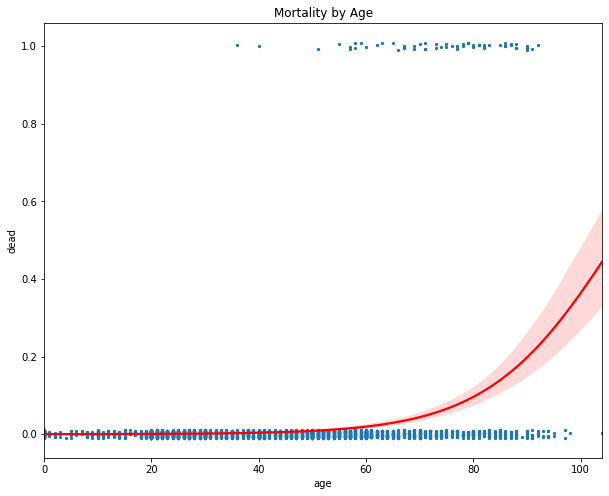

In [15]:
plt.figure(figsize=(10, 8))
plt.title("Mortality by Age")
ax3 = sns.regplot(x='age', y='dead', data=data, y_jitter=0.01, logistic=True, truncate=True, 
                  scatter_kws={'s':5, 'alpha':1}, line_kws={'color':'red'})

First, we modify the data to feed into the model. This essentially entails filling in null values, and converting all strings to their numerical form. For example, we know that sex is an important co-morbidity in coronavirus complications. We can encode it using a technique called <a href='https://en.wikipedia.org/wiki/One-hot'>one-hot encoding</a>. For more complicated scenarios like filling in null values, there are a variety of options. The route I have chosen is to use the mean of the variable across all entries.

In [16]:
model = data.copy()
model['bias'] = 1.0 #intercept term
model['time_in_hospital'] = model['time_in_hospital'].\
                                    fillna(np.mean(data['time_in_hospital'])).\
                                    apply(pd.Timedelta.total_seconds) / (24*60*60)
model['sex'] = (model['sex'].factorize()[0]).astype(int) #one-hot encode sex
model.head()

,sex,country,province,city,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,age,time_before_hospitalization,time_in_hospital,dead,bias
0,0,Korea,Seoul,Gangseo-gu,overseas inflow,1.0,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0,1 days,13.0,0,1.0
1,0,Korea,Seoul,Jungnang-gu,overseas inflow,1.0,31.0,NaT,2020-01-30,2020-03-02,NaN,released,33.0,NaT,32.0,0,1.0
2,0,Korea,Seoul,Jongno-gu,contact with patient,2.0,17.0,NaT,2020-01-30,2020-02-19,NaN,released,56.0,NaT,20.0,0,1.0
3,0,Korea,Seoul,Mapo-gu,overseas inflow,1.0,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0,4 days,16.0,0,1.0
4,1,Korea,Seoul,Seongbuk-gu,contact with patient,2.0,2.0,NaT,2020-01-31,2020-02-24,NaN,released,28.0,NaT,24.0,0,1.0


I have decided on a 4 dimensional logistic regression (1 intercept term + 3 variables). The equation for our model below is: 
$$P(death) = \sigma(\beta_{0}+\beta_{1}*x_1+\beta_{2}*x_2+\beta_{3}*x_3)$$
Where <a href='https://en.wikipedia.org/wiki/Sigma_function'>sigma</a> is defined as $$\sigma(t)=\frac{1}{1+e^{-t}}$$ and $x_1, x_2, x_3$ are our variables (age, sex, time in hospital).

The logistic regression model solves for optimal betas, where optimal is defined as minimizing some loss function. Logistic regression generally uses <a href='https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression'>cross-entropy loss</a>.

In [17]:
def vectorize(t, features, y):
    return t[features].values.T, t[y].values

features = ['bias', 'age', 'sex', 'time_in_hospital']
X_train, y_train = vectorize(t=model, features=features, y='dead')

In [18]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(fit_intercept=False, C=1e9, solver='lbfgs')
lr.fit(X_train.T, y_train)

for i in range(len(features)):
    print(features[i] + " coefficient: " + str(lr.coef_[0][i]))

bias coefficient: -8.392651804457564
age coefficient: 0.09238093162215619
sex coefficient: -1.4829568336690335
time_in_hospital coefficient: -0.02228844707944757


In [19]:
def sigma(t):
    return 1 / (1 + np.e**(-t))

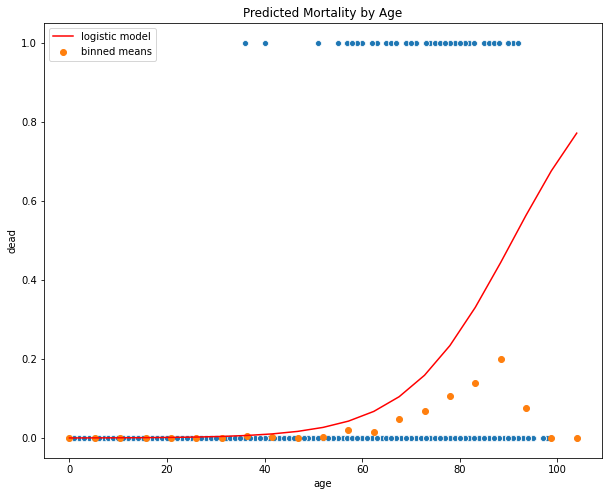

In [20]:
age_bins = np.linspace(np.min(model['age']), np.max(model['age']), 21)
averages = [np.average(model[np.abs(model['age']-a)<3]['dead']) for a in age_bins]
plt.figure(figsize=(10, 8))
plt.title("Predicted Mortality by Age")
ax4 = sns.scatterplot(x='age', y='dead', data=model)
plt.scatter(age_bins, averages, label = 'binned means')
plt.plot(age_bins, sigma(lr.coef_[0][0] + age_bins * lr.coef_[0][1]), color='r', label = 'logistic model')
suppressor = plt.legend()

Above we have plotted a 2-dimensional cross-section of our 4 dimensional model. Time in hospital and sex have been projected onto the age-dead plane.

## Classification ##
Finally, we can use our trained model to predict the probability of dying from COVID given our feature variables. Classification, accuracy, precision, and recall are not directly applicable here as we simply want a probability given out input. These "extra" metrics are generally used to determine the viability of our model on unseen data.

In [21]:
def predict(X, betas):
    return sigma(X.T @ betas)

def classify(preds, threshold = 0.5):
    return np.int64(preds >= threshold)
    
def accuracy(actual, pred):
    return np.mean(actual == pred)

def precision(actual, pred):
    tp = sum((actual == pred) & (actual == 1))
    tn = sum((actual == pred) & (actual == 0))
    fp = sum((actual != pred) & (actual == 0))
    fn = sum((actual != pred) & (actual == 1))
    return tp / (tp + fp)

def recall(actual, pred):
    tp = sum((actual == pred) & (actual == 1))
    tn = sum((actual == pred) & (actual == 0))
    fp = sum((actual != pred) & (actual == 0))
    fn = sum((actual != pred) & (actual == 1))
    return tp / (tp + fn)

In [22]:
from itertools import product
prob = []
for a, s, t in product(np.linspace(1, 100, 100), 
                       (0, 1),
                       np.linspace(1, 40, 40)):
    prob.append([a, s+101, t] + [predict(np.array([1, a, s, t]), lr.coef_[0])])
    
predictions = pd.DataFrame(np.array(prob)).\
                rename(columns={0: 'age', 1: 'sex', 2: 'time in hospital', 3: 'probability'}).\
                replace({101: 'male', 102:'female'})
predictions.head()

,age,sex,time in hospital,probability
0,1.0,male,1.0,0.000243
1,1.0,male,2.0,0.000238
2,1.0,male,3.0,0.000232
3,1.0,male,4.0,0.000227
4,1.0,male,5.0,0.000222


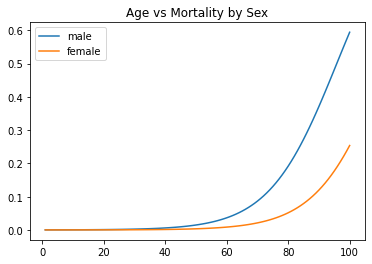

In [23]:
male = predictions[predictions['sex']=='male'].groupby('age').mean()
female = predictions[predictions['sex']=='female'].groupby('age').mean()
plt.title("Age vs Mortality by Sex")
ax5 = plt.plot(male.index, male['probability'], label='male')
ax5 = plt.plot(female.index, female['probability'], label='female')
suppressor = plt.legend()

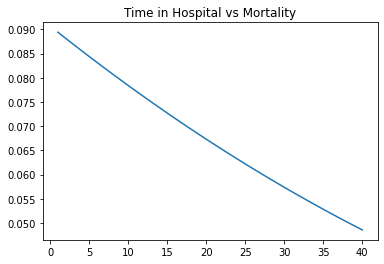

In [24]:
hospital = predictions.groupby('time in hospital').mean()
plt.title("Time in Hospital vs Mortality")
ax6 = plt.plot(hospital.index, hospital['probability'])

In conclusion, we can see that even a limited amout of data can reveal profound facts. Specifically, we initially noted that median time spent in a hospital were elevated in infections caused in either a nursing home (high age) or silver mine (poor respiratory health). In hindsight, these details that unbiasedly popped out of the data, can reveal the pathology of the virus.

Most importantly, however, the coronavirus has stressed the importance of data-driven healthcare. It is easy to see how physician-scientists of the future can incorporate medical knowledge with data technologies to improve global healthcare. 